# Tutorial 5: Discern biologically distinct anomalous tissue subdomains in single ST datasets

We use STANDS to discern biologically distinct anomalous tissue subdomains in single ST datasets. Specifically, this experiment involves a normal breast tissue dataset (10x-hNB-v05) and a breast cancer datasets (10x-hBC-G2). The cancer in situ and invasive cancer in 10x-hBC-G2 are regarded as the anomaly subdomains.

## Loading package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import stands
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

## Reading ST data

We read the processed ST datasets. In the example, the demo datasets includes: 1) gene expression matrix in `adata.X`; 2) spatial coordinates in `adata.obsm['spatial']`; 3) histology image in `adata.uns['spatial']`. To make the model can read the data sucessfully, please ensure the same anndata structure as example.

In [3]:
ref = sc.read_h5ad('./HumanBreast/process/V05.h5ad')
tgt = sc.read_h5ad('./HumanBreast/process/G2.h5ad')

In [4]:
ref

AnnData object with n_obs × n_vars = 2224 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
tgt

AnnData object with n_obs × n_vars = 467 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

## Converting data

For ST input, STANDS first needs to convert the anndata data into a graph, where nodes represent each spot and edges represent the adjacency relationship between two spots. In the example, the node features of the converted graph include the gene expression vector and image patch. Additionally, if the data has been preprocessed, you should set `preprocess=False`.

In [6]:
ref_g = stands.read(ref, patch_size=64, n_genes=3000, preprocess=False)
tgt_g = stands.read(tgt, patch_size=64, n_genes=3000, preprocess=False)

## Detecting anomaly domains

The anomaly subtype module of STANDS is implemented based on the anomaly detection module. Firstly, the anomalous regions on the target dataset need to be detected using STANDS.

In [7]:
ADModel = stands.AnomalyDetect()
ADModel.fit(ref_g)

Begin to train the model on reference datasets...


Train Epochs: 100%|██████████| 10/10 [02:47<00:00, 16.79s/it, D_Loss=0.0395, G_Loss=2.14]

Training has been finished.


In [8]:
score, label = ADModel.predict(tgt_g)

Detect anomalous spots on target dataset...
Anomalous spots have been detected.



In [9]:
# store the results
tgt.obs['score'] = score
tgt.obs['pred'] = label

In [10]:
anomaly = tgt[tgt.obs['pred']==1]

## Training the model

In the anomaly subtype module of STANDS, since the generator of the anomaly detection module is used as extractor, it is also necessary to convert the anomaly data.

In [11]:
# convert detected anomaliesw
anomaly_g = stands.read(anomaly, patch_size=64, n_genes=3000, preprocess=False)

In [12]:
ASModel = stands.Subtype(ADModel.G)
subtype = ASModel.fit(anomaly_g)

Train Epochs: 100%|██████████| 3000/3000 [02:24<00:00, 20.72it/s, Loss=0.00127] 


In [13]:
# store the result
anomaly.obs['subtype'] = subtype
normal = tgt[tgt.obs['pred']==0]
normal.obs['subtype'] = 0
tgt.obs = pd.concat([anomaly.obs, normal.obs]).sort_index()
tgt.obs['subtype'] = tgt.obs['subtype'].astype('int')

## Evaluation

STANDS integrates several evaluation metrics in `stands.evaluate` for anomaly detection tasks, which can be used very easily and directly.

In [14]:
# annotate ground truth labels
df = pd.DataFrame(tgt.obs)
df['sub_label'] = np.nan

# disease == 1
disease_1_df = df[df['disease'] == 1].copy()
unique_cell_types = disease_1_df['cell_type'].unique()
subtype_mapping = {cell_type: i+1 for i, cell_type in enumerate(unique_cell_types)}
disease_1_df['sub_label'] = disease_1_df['cell_type'].map(subtype_mapping)

# disease == 0
disease_0_df = df[df['disease'] == 0].copy()
disease_0_df['sub_label'] = 0

df = pd.concat([disease_1_df, disease_0_df]).sort_index()
df['sub_label'] = df['sub_label'].astype('category')
df['subtype'] = df['subtype'].astype('category')

tgt.obs = df

In [15]:
metrics = ['F1*NMI', 'SGD_degree', 'SGD_cc']
result = stands.evaluate(metrics, adata=tgt, y_true=tgt.obs['disease'], y_pred=tgt.obs['pred'],
                         spaid='spatial', typeid='cell_type', clustid='subtype')

In [16]:
pd.DataFrame(zip(metrics, result))

0         1
0      F1*NMI  0.357314
1  SGD_degree  0.936548
2      SGD_cc  0.510951

## Visualization

We use the spatial map to visualise the results of anomaly detection.

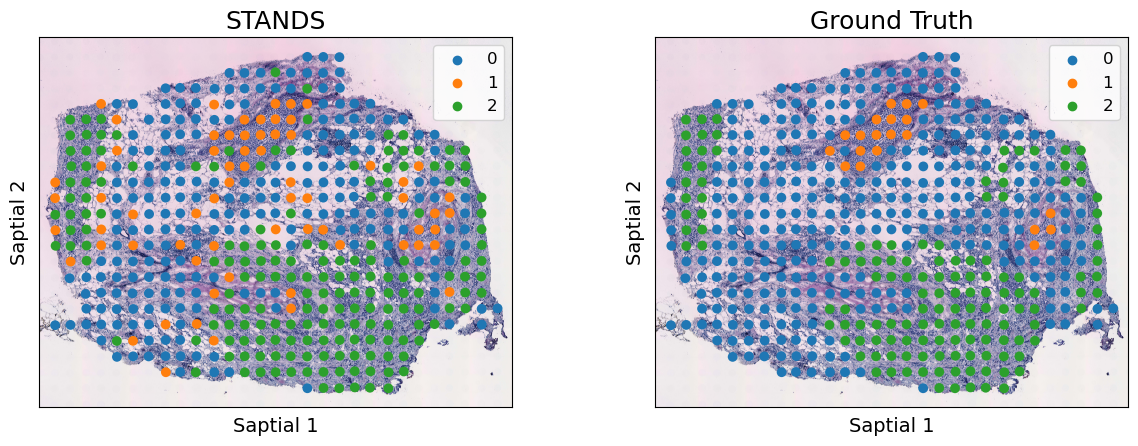

In [17]:
ax = sc.pl.spatial(tgt, color=['subtype', 'sub_label'], s=90, show=False, crop_coord=(0, 8700, 800, 7600))

ax[0].legend(fontsize=12)
ax[0].set_title('STANDS', fontsize=18)
ax[0].set_xlabel('Saptial 1', fontsize=14)
ax[0].set_ylabel('Saptial 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('Ground Truth', fontsize=18)
ax[1].set_xlabel('Saptial 1', fontsize=14)
ax[1].set_ylabel('Saptial 2', fontsize=14)

plt.show()